# Titanic: Machine Learning from Disaster

* Description:
    The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
* Problem definition: In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [57]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)





// 依据 ipynb 文件名, 给 cell 加上特定的背景色
String.prototype.hashCode = function() {
  var hash = 0, i, chr;
  if (this.length === 0) return hash;
  for (i = 0; i < this.length; i++) {
    chr   = this.charCodeAt(i);
    hash  = ((hash << 5) - hash) + chr;
    hash |= 0; // Convert to 32bit integer
  }
  return hash;
};

function random_hue_color(label, s, l) {
  // console.log(Math.abs(label.hashCode()))
  var hash_color = (Math.abs(label.hashCode()) % 360) / 360 * 100
  return `hsl(${hash_color}, ${s}%, ${l}%)`
}

var notebook_path = IPython.notebook.notebook_path
var color1 = random_hue_color(notebook_path, 20, 90)
var color2 = random_hue_color(notebook_path, 40, 80)

var css = document.createElement("style")
css.type = "text/css"
css.innerHTML = `div.cell {background-color: ${color1};}`
css.innerHTML +=`div.running {background-color: ${color2};}`
css.innerHTML +=`div.running.selected {background-color: ${color2};}`
css.innerHTML +='</style>'
document.body.appendChild(css);


<IPython.core.display.Javascript object>

## Data Exploration

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
print ("Dimension of train data {}".format(train.shape))
print ("Dimension of test data {}".format(test.shape))

Dimension of train data (891, 12)
Dimension of test data (418, 11)


In [61]:
print ("Basic statistical description:")
train.describe()

Basic statistical description:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Comparison between test and train data

#### From following cells, we could know that train and test data are split by PassengerId.

In [62]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [63]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Let's look at data graphically. We could see that all the distribution of features are similar.

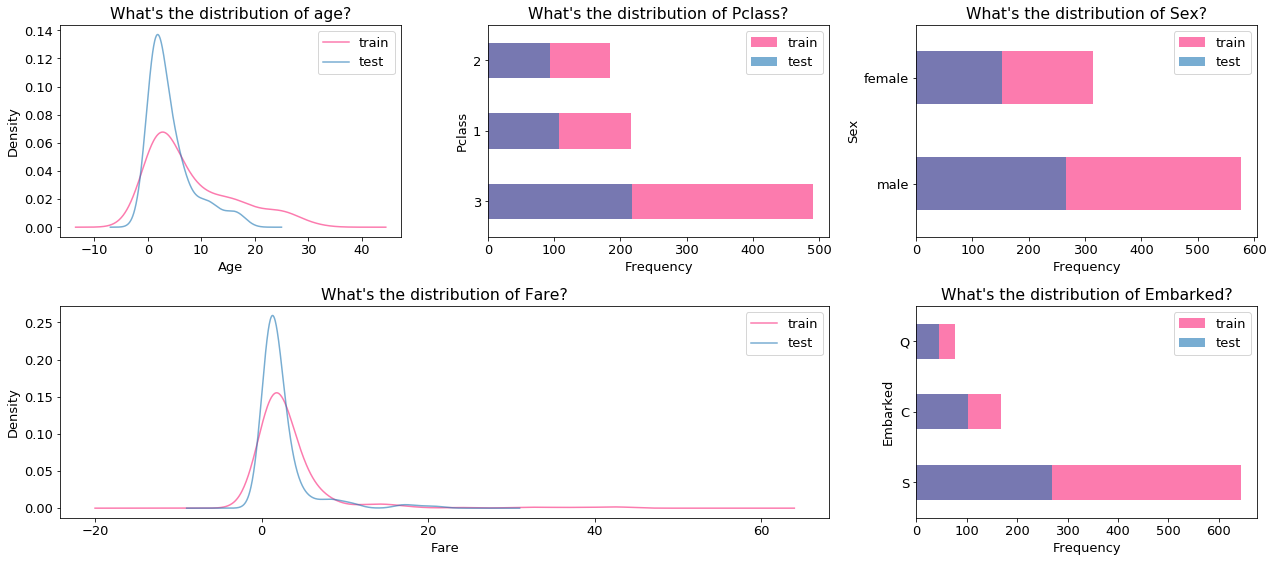

In [64]:
plt.rc('font', size=13)
fig = plt.figure(figsize=(18, 8))
alpha = 0.6


# KDE 核密度函数
# 在我们知道某一事物的概率分布的情况下，
# 如果某一个数在观察中出现了，我们可以认为这个数的概率密度很大，
# 和这个数比较近的数的概率密度也会比较大，而那些离这个数远的数的概率密度会比较小

ax1 = plt.subplot2grid((2,3), (0,0))
train.Age.value_counts().plot(kind='kde', color='#FA2379', label='train', alpha=alpha)
test.Age.value_counts().plot(kind='kde', label='test', alpha=alpha)
ax1.set_xlabel('Age')
ax1.set_title("What's the distribution of age?" )
plt.legend(loc='best')

ax2 = plt.subplot2grid((2,3), (0,1))
train.Pclass.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.Pclass.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax2.set_ylabel('Pclass')
ax2.set_xlabel('Frequency')
ax2.set_title("What's the distribution of Pclass?" )
plt.legend(loc='best')

ax3 = plt.subplot2grid((2,3), (0,2))
train.Sex.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.Sex.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax3.set_ylabel('Sex')
ax3.set_xlabel('Frequency')
ax3.set_title("What's the distribution of Sex?" )
plt.legend(loc='best')

ax4 = plt.subplot2grid((2,3), (1,0), colspan=2)
train.Fare.value_counts().plot(kind='kde', color='#FA2379', label='train', alpha=alpha)
test.Fare.value_counts().plot(kind='kde', label='test', alpha=alpha)
ax4.set_xlabel('Fare')
ax4.set_title("What's the distribution of Fare?" )
plt.legend(loc='best')

ax5 = plt.subplot2grid((2,3), (1,2))
train.Embarked.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.Embarked.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax5.set_ylabel('Embarked')
ax5.set_xlabel('Frequency')
ax5.set_title("What's the distribution of Embarked?" )
plt.legend(loc='best')
plt.tight_layout()

为什么 Age 出现负数? 平滑的概率推断造成的?

#### We could know that the numbers of survived and died people are close to balanced.

In [65]:
print (train.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


### Look closely to the train data

#### We could see that the density of survived is higher than not survived under age 10.

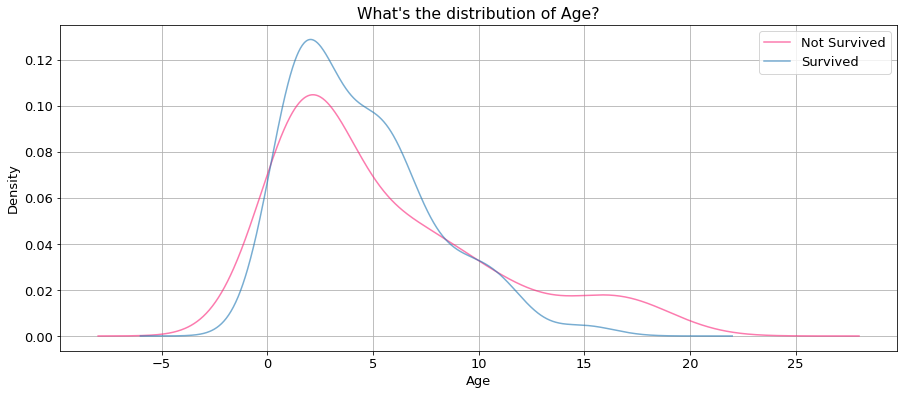

In [66]:
fig = plt.figure(figsize=(15, 6))

train[train.Survived==0].Age.value_counts().plot(kind='density', color='#FA2379', label='Not Survived', alpha=alpha)
train[train.Survived==1].Age.value_counts().plot(kind='density', label='Survived', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age?" )
plt.legend(loc='best')
plt.grid()

#### We could observe that the survived rate of female is higher than male about 50%

这种横向的bar图怎么那么别扭呢, 还不如纵向, 或者饼图

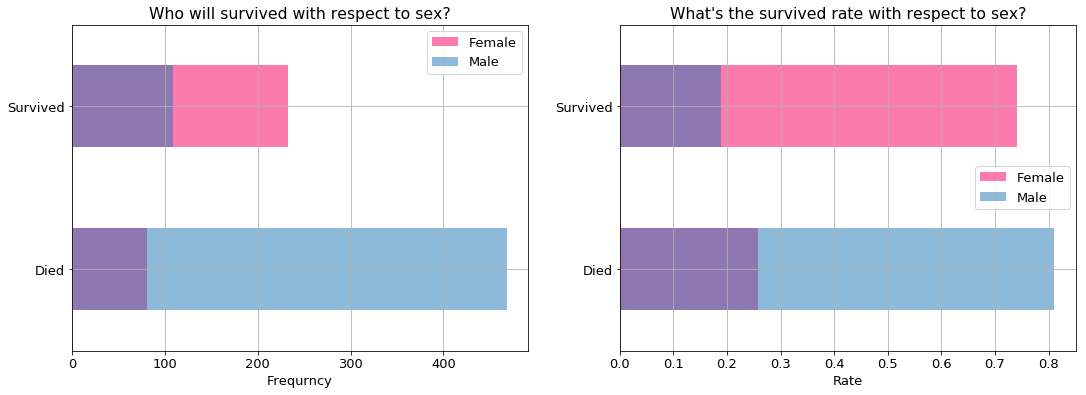

In [67]:
df_male = train[train.Sex=='male'].Survived.value_counts().sort_index()
df_female = train[train.Sex=='female'].Survived.value_counts().sort_index()
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((1,2), (0,0))
df_female.plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
df_male.plot(kind='barh', label='Male', alpha=alpha-0.1)
ax1.set_xlabel('Frequrncy')
ax1.set_yticklabels(['Died', 'Survived'])
ax1.set_title("Who will survived with respect to sex?" )
plt.legend(loc='best')
plt.grid()

ax2 = plt.subplot2grid((1,2), (0,1))
(df_female/train[train.Sex=='female'].shape[0]).plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
(df_male/train[train.Sex=='male'].shape[0]).plot(kind='barh', label='Male', alpha=alpha-0.1)
ax2.set_xlabel('Rate')
ax2.set_yticklabels(['Died', 'Survived'])
ax2.set_title("What's the survived rate with respect to sex?" )
plt.legend(loc='best')
plt.grid()

#### We could observed that the class of people affected the posibility of being survived.

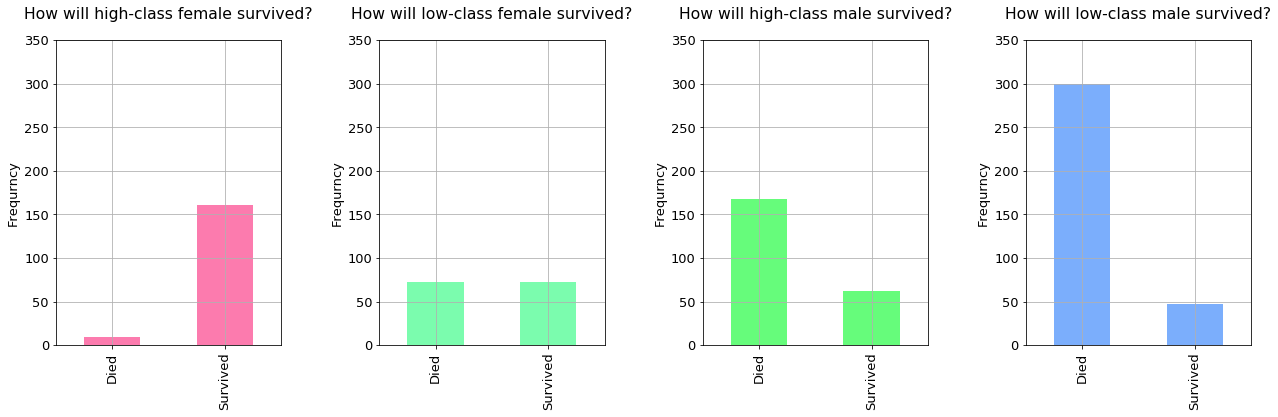

In [68]:
df_male = train[train.Sex=='male']
df_female = train[train.Sex=='female']
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((1,4), (0,0))
df_female[df_female.Pclass<3].Survived.value_counts().sort_index().plot(kind='bar', color='#FA2379', alpha=alpha)
ax1.set_ylabel('Frequrncy')
ax1.set_ylim((0,350))
ax1.set_xticklabels(['Died', 'Survived'])
ax1.set_title("How will high-class female survived?", y=1.05)
plt.grid()

ax2 = plt.subplot2grid((1,4), (0,1))
df_female[df_female.Pclass==3].Survived.value_counts().sort_index().plot(kind='bar', color='#23FA79', alpha=alpha)
ax2.set_ylabel('Frequrncy')
ax2.set_ylim((0,350))
ax2.set_xticklabels(['Died', 'Survived'])
ax2.set_title("How will low-class female survived?", y=1.05)
plt.grid()

ax3 = plt.subplot2grid((1,4), (0,2))
df_male[df_male.Pclass<3].Survived.value_counts().sort_index().plot(kind='bar', color='#00FA23', alpha=alpha)
ax3.set_ylabel('Frequrncy')
ax3.set_ylim((0,350))
ax3.set_xticklabels(['Died', 'Survived'])
ax3.set_title("How will high-class male survived?", y=1.05)
plt.grid()

ax4 = plt.subplot2grid((1,4), (0,3))
df_male[df_male.Pclass==3].Survived.value_counts().sort_index().plot(kind='bar', color='#2379FA', alpha=alpha)
ax4.set_ylabel('Frequrncy')
ax4.set_ylim((0,350))
ax4.set_xticklabels(['Died', 'Survived'])
ax4.set_title("How will low-class male survived?", y=1.05)
plt.grid()
plt.tight_layout()

#### We could see that if the value of Ticket is the same, passenger would be close, like friends or familes. But sometimes it will not be the case, so we need to carefully handle it.

In [69]:
train[train.Ticket=='1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [70]:
train[train.Ticket=='CA 2144']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S


## Data Cleaning

#### Let's see how many missing values we have on each column. 

In [71]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [72]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Thanks for [this amazing sharing](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook), now we have a good way to replace missing values with sensible values. Let's assume the embarked is related with fare and pclass.

### Missing values on Embarked

,Fare,Pclass,Embarked
61,80.0,1,NaN
829,80.0,1,NaN


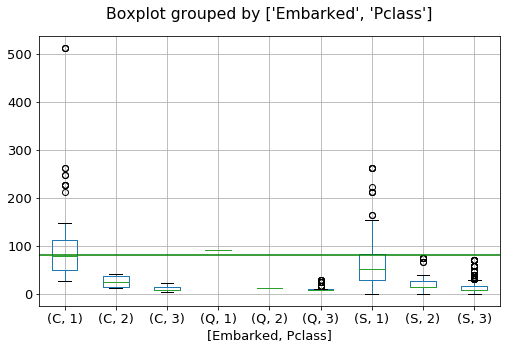

In [73]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax = train.boxplot(column='Fare', by=['Embarked','Pclass'], ax=ax)
plt.axhline(y=80, color='green')
ax.set_title('', y=1.1)

train[train.Embarked.isnull()][['Fare', 'Pclass', 'Embarked']]

#### From the above boxplot, we should replace NA with C because most people who had Pclass 1 and Fare 80 would be Embarked C


箱线图 | Yixf's blog
http://yixf.name/2011/02/13/%E7%AE%B1%E7%BA%BF%E5%9B%BE/

In [74]:
_ = train.set_value(train.Embarked.isnull(), 'Embarked', 'C')

### Missing values on Fare

#### By fixing the values of Embarked (and Pclass?), we could plot histogram of Fare. And we should use the most common value to replace the NA value of Fare.


,Pclass,Fare,Embarked
152,3,NaN,S


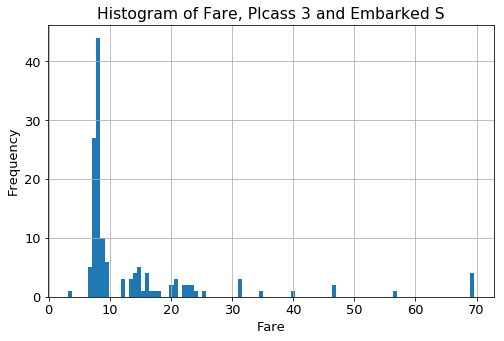

In [75]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
test[(test.Pclass==3)&(test.Embarked=='S')].Fare.hist(bins=100, ax=ax)
test[test.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare, Plcass 3 and Embarked S')

test[test.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]

In [76]:
print ("The top 5 most common value of Fare")
test[(test.Pclass==3)&(test.Embarked=='S')].Fare.value_counts().head()

# 恩, 取个众数就可以了, 不必要 kde 什么的

The top 5 most common value of Fare


8.0500    17
7.8958    10
7.7750    10
8.6625     8
7.8542     8
Name: Fare, dtype: int64

In [77]:
_ = test.set_value(test.Fare.isnull(), 'Fare', 8.05)

#### Replace the missing value of Cabin with U0

In [78]:
# 缺失值太多的, 就没法补了, 分类值直接设一个 unknown

# pd.concat field 不一致都可以? test 缺 Survived 属性
full = pd.concat([train, test], ignore_index=True)
_ = full.set_value(full.Cabin.isnull(), 'Cabin', 'U0')

In [79]:
full.isnull().sum()
# age 咋整?

Age            263
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

## Feature Engineering

#### Create a feature, Names, to store the length of words in name.

In [80]:
print(full.Name.head(20))

import re
names = full.Name.map(lambda x: len(re.split(' ', x)))
_ = full.set_value(full.index, 'Names', names)
del names

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

#### Create a feature, Title.

In [81]:
title = full.Name.map(lambda x: re.compile(', (.*?)\.').findall(x)[0])
title[title=='Mme'] = 'Mrs'
title[title.isin(['Ms','Mlle'])] = 'Miss'
title[title.isin(['Don', 'Jonkheer'])] = 'Sir'
title[title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
title[title.isin(['Capt', 'Col', 'Major', 'Dr', 'Officer', 'Rev'])] = 'Officer'
_ = full.set_value(full.index, 'Title', title)
del title

#### Create a feature, Deck. It may represents the socioeconomic status.

In [82]:
print(full.Cabin.head(20))
deck = full[~full.Cabin.isnull()].Cabin.map( lambda x: re.compile("([a-zA-Z]+)").search(x).group())
# print(deck)
# factorize 把不同分类每一种标记为 int
deck = pd.factorize(deck)[0]
print(list(deck)[:40])
_ = full.set_value(full.index, 'Deck', deck)
del deck

0       U0
1      C85
2       U0
3     C123
4       U0
5       U0
6      E46
7       U0
8       U0
9       U0
10      G6
11    C103
12      U0
13      U0
14      U0
15      U0
16      U0
17      U0
18      U0
19      U0
Name: Cabin, dtype: object
[0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]


#### Create a feature, Room. It may represents the geo lacation.

In [83]:
checker = re.compile("([0-9]+)")
def roomNum(x):
    nums = checker.search(x)
    if nums:
        return int(nums.group())+1
    else:
        return 1
rooms = full.Cabin.map(roomNum)
print(list(rooms)[:40])
_ = full.set_value(full.index, 'Room', rooms)
del checker, roomNum
full['Room'] = full.Room/full.Room.sum()

[1, 86, 1, 124, 1, 1, 47, 1, 1, 1, 7, 104, 1, 1, 1, 1, 1, 1, 1, 1, 1, 57, 1, 7, 1, 1, 1, 24, 1, 1, 1, 79, 1, 1, 1, 1, 1, 1, 1, 1]


#### Create a feature, Group_num. It may represents the size of family.

In [84]:
full['Group_num'] = full.Parch + full.SibSp + 1

#### Create a feature, Group_size. When the size is between 2 and 4, more people are survived.

In [85]:
full['Group_size'] = pd.Series('M', index=full.index)
_ = full.set_value(full.Group_num>4, 'Group_size', 'L')
_ = full.set_value(full.Group_num==1, 'Group_size', 'S')

#### Normalized the fare.

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
full['NorFare'] = pd.Series(scaler.fit_transform(full.Fare.values.reshape(-1,1)).reshape(-1), index=full.index)

In [87]:
def setValue(col):
    _ = train.set_value(train.index, col, full[:891][col].values)
    _ = test.set_value(test.index, col, full[891:][col].values)

for col in ['Deck', 'Room', 'Group_size', 'Group_num', 'Names', 'Title']:
    setValue(col)
    
    
# 这是啥意思? 把 full 的数据写回到 train 和 test?

#### Predict Age

In [88]:
full.drop(labels=['PassengerId', 'Name', 'Cabin', 'Survived', 'Ticket', 'Fare'], axis=1, inplace=True)
full = pd.get_dummies(full, columns=['Embarked', 'Sex', 'Title', 'Group_size'])

In [89]:
from sklearn.model_selection import train_test_split
X = full[~full.Age.isnull()].drop('Age', axis=1)
y = full[~full.Age.isnull()].Age
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [90]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_  # _ => ?
    

In [91]:
# pause, install xgboost
# 安装 XGBoost on Win10
# Download XGBoost Windows x64 Binaries and Executables
# http://www.picnet.com.au/blogs/guido/post/2016/09/22/xgboost-windows-x64-binaries-for-download/

import xgboost as xgb

XGB = xgb.XGBRegressor(max_depth=4, seed=42)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
parameters = {'reg_alpha': np.linspace(0.1, 1.0, 5), 'reg_lambda': np.linspace(1.0, 3.0, 5)}
reg_xgb = get_model(XGB, parameters, X_train, y_train, scoring)
print(reg_xgb)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0.55000000000000004,
       reg_lambda=3.0, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)


In [92]:
print("Mean absolute error of test data: {}".format(mean_absolute_error(y_test, reg_xgb.predict(X_test))))

Mean absolute error of test data: 7.728310931438709


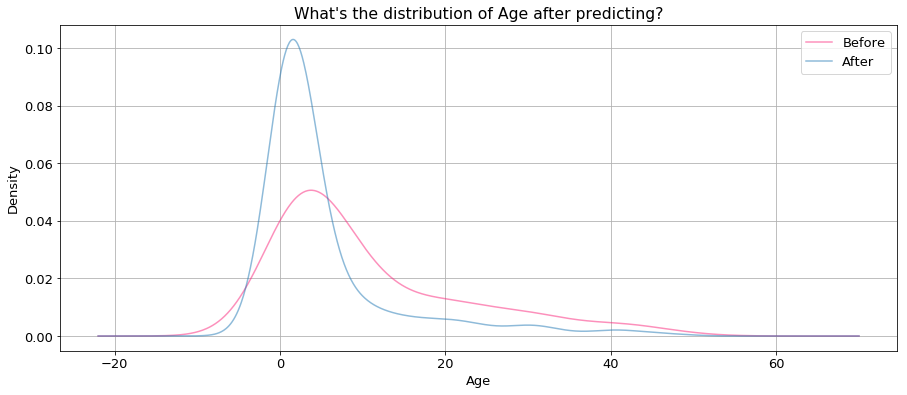

In [93]:
fig = plt.figure(figsize=(15, 6))
alpha = 0.5
full.Age.value_counts().plot(kind='density', color='#FA2379', label='Before', alpha=alpha)

pred = reg_xgb.predict(full[full.Age.isnull()].drop('Age', axis=1))
full.set_value(full.Age.isnull(), 'Age', pred)

full.Age.value_counts().plot(kind='density', label='After', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age after predicting?" )
plt.legend(loc='best')
plt.grid()

In [94]:
full['NorAge'] = pd.Series(scaler.fit_transform(full.Age.values.reshape(-1,1)).reshape(-1), index=full.index)
full['NorNames'] = pd.Series(scaler.fit_transform(full.Names.values.reshape(-1,1)).reshape(-1), index=full.index)
full['Group_num'] = pd.Series(scaler.fit_transform(full.Group_num.values.reshape(-1,1)).reshape(-1), index=full.index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [95]:
for col in ['NorAge', 'NorFare', 'NorNames', 'Group_num']:
    setValue(col)

#### Encoding sex, feamle: 0 and male: 1

In [96]:
train.Sex = np.where(train.Sex=='female', 0, 1)
test.Sex = np.where(test.Sex=='female', 0, 1)

#### Convert values of Embarked and Ticket into dummy variables

In [97]:
train.drop(labels=['PassengerId', 'Name', 'Names', 'Cabin', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)
test.drop(labels=['Name', 'Names', 'Cabin', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)

In [98]:

train = pd.get_dummies(train, columns=['Embarked', 'Pclass', 'Title', 'Group_size'])
test = pd.get_dummies(test, columns=['Embarked', 'Pclass', 'Title', 'Group_size'])


# 这里不该有 test['Title_Sir'] 赋值, 会造成该字段位置不符, 
# 好吧, 还是应该有, 因为 train 有 Sir ,也许 test 里恰好没有 Sir
# test['Title_Sir'] = pd.Series(0, index=test.index)

## Build Model

In [99]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [100]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(estimator, X, y, title):
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(y, estimator.predict_proba(X)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print ('ROC AUC: %0.2f' % roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [101]:
X = train.drop(['Survived'], axis=1)
y = train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [102]:
from sklearn.metrics import accuracy_score
scoring = make_scorer(accuracy_score, greater_is_better=True)

### KNN

In [103]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(weights='uniform')
parameters = {'n_neighbors':[3,4,5], 'p':[1,2]}
clf_knn = get_model(KNN, parameters, X_train, y_train, scoring)

0.816143497758
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')


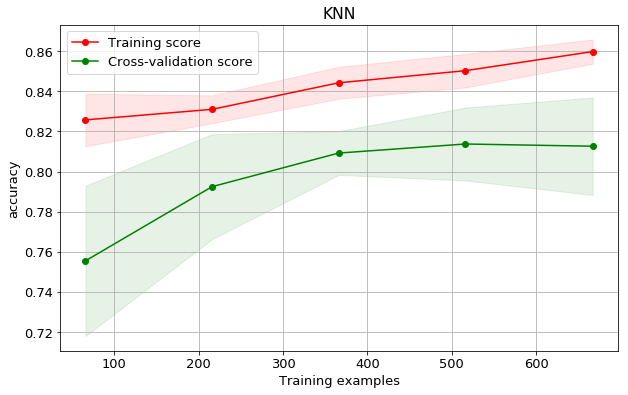

In [104]:
print(accuracy_score(y_test, clf_knn.predict(X_test)))
print(clf_knn)
plot_learning_curve(clf_knn, 'KNN', X, y, cv=4);

### Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_split=5, oob_score=True)
parameters = {'n_estimators':[500], 'min_samples_leaf':[12]}
clf_rfc1 = get_model(rfc, parameters, X_train, y_train, scoring)

0.829596412556
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=12,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)


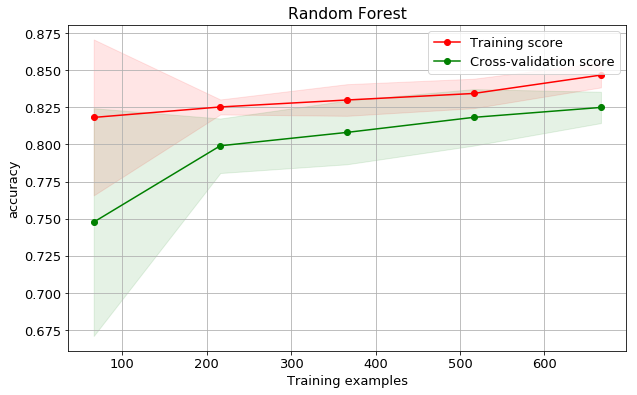

In [106]:
print (accuracy_score(y_test, clf_rfc1.predict(X_test)))
print (clf_rfc1)
plot_learning_curve(clf_rfc1, 'Random Forest', X, y, cv=4);

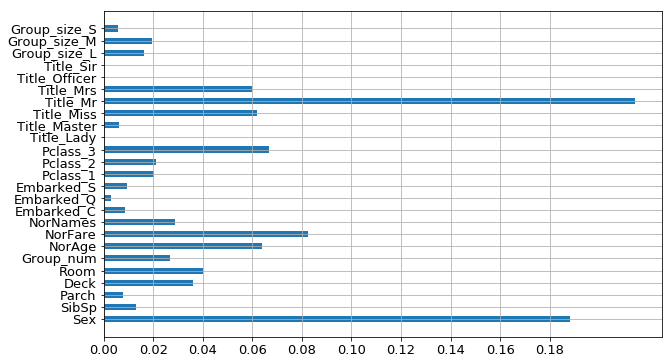

In [107]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(X_train.columns.shape[0]), clf_rfc1.feature_importances_, 0.5)
plt.yticks(np.arange(X_train.columns.shape[0]), X_train.columns)
plt.grid()
plt.xticks(np.arange(0,0.2,0.02));

In [108]:
cols = X_train.columns[clf_rfc1.feature_importances_>=0.016]

In [109]:
rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_split=5, oob_score=True)
parameters = {'n_estimators':[500], 'min_samples_leaf':[12]}
clf_rfc2 = get_model(rfc, parameters, X_train[cols], y_train, scoring)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=12,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
0.834080717489


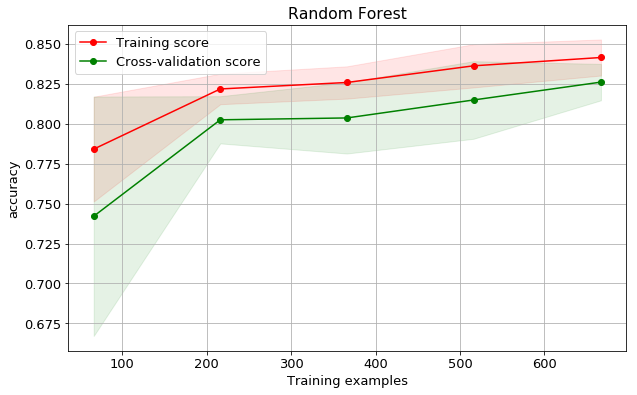

In [110]:
print(clf_rfc2)
print(accuracy_score(y_test, clf_rfc2.predict(X_test[cols])))
plot_learning_curve(clf_rfc2, 'Random Forest', X[cols], y, cv=4);

### Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=42, penalty='l1')
parameters = {'C':[0.5]}
clf_lg1 = get_model(lg, parameters, X_train, y_train, scoring)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.816143497758


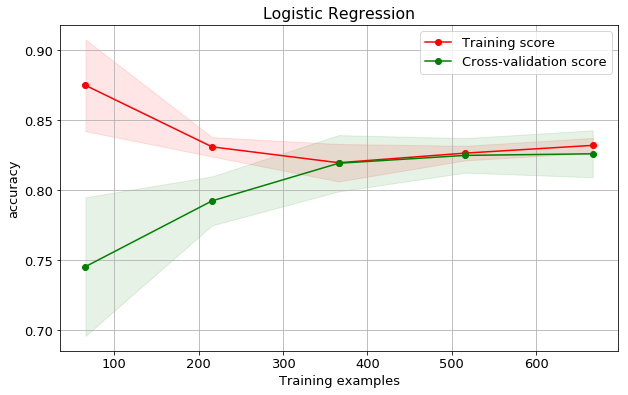

In [112]:
print (clf_lg1)
print (accuracy_score(y_test, clf_lg1.predict(X_test)))
plot_learning_curve(clf_lg1, 'Logistic Regression', X, y, cv=4);

### SVC

In [113]:
from sklearn.svm import SVC
svc = SVC(random_state=42, kernel='poly', probability=True)
parameters = {'C': [35], 'gamma': [0.0055], 'coef0': [0.1],
              'degree':[2]}
clf_svc = get_model(svc, parameters, X_train, y_train, scoring)

SVC(C=35, cache_size=200, class_weight=None, coef0=0.1,
  decision_function_shape=None, degree=2, gamma=0.0055, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
0.838565022422


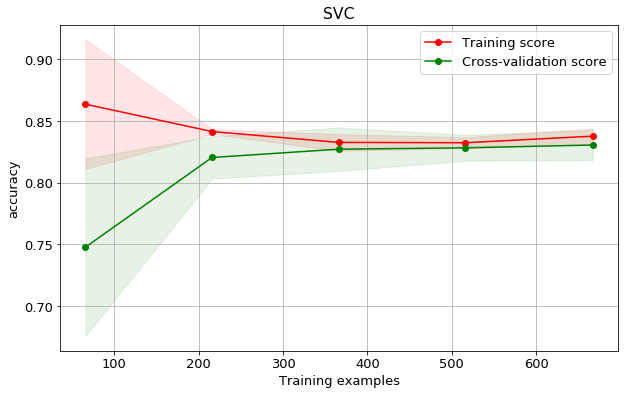

In [114]:
print(clf_svc)
print(accuracy_score(y_test, clf_svc.predict(X_test)))
plot_learning_curve(clf_svc, 'SVC', X, y, cv=4);

### XGBoost

In [115]:
import xgboost as XGB
xgb = XGB.XGBClassifier(seed=42, max_depth=3, objective='binary:logistic', n_estimators=400)
parameters = {'learning_rate':[0.1],
              'reg_alpha':[3.0], 'reg_lambda': [4.0]}
clf_xgb1 = get_model(xgb, parameters, X_train, y_train, scoring)

0.820627802691
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=3.0, reg_lambda=4.0,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)


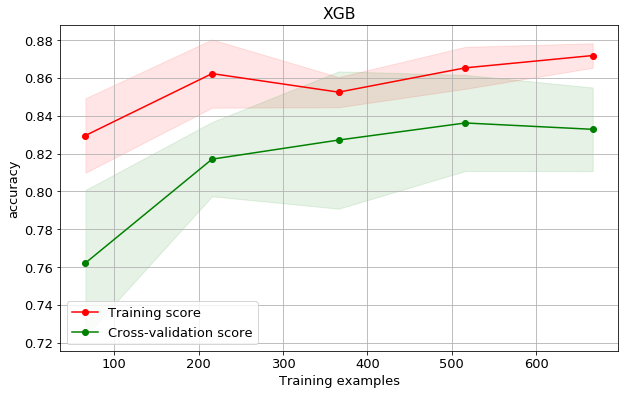

In [116]:
print (accuracy_score(y_test, clf_xgb1.predict(X_test)))
print (clf_xgb1)
plot_learning_curve(clf_xgb1, 'XGB', X, y, cv=4);

## Ensemble

In [117]:
from sklearn.ensemble import VotingClassifier
clf_vc = VotingClassifier(estimators=[('xgb1', clf_xgb1), ('lg1', clf_lg1), ('svc', clf_svc), 
                                      ('rfc1', clf_rfc1),('rfc2', clf_rfc2), ('knn', clf_knn)], 
                          voting='hard', weights=[4,1,1,1,1,2])
clf_vc = clf_vc.fit(X_train, y_train)

0.825112107623
VotingClassifier(estimators=[('xgb1', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=3.0, reg_lambda=4.0,
    ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform'))],
         n_jobs=1, voting='hard', weights=[4, 1, 1, 1, 1, 2])


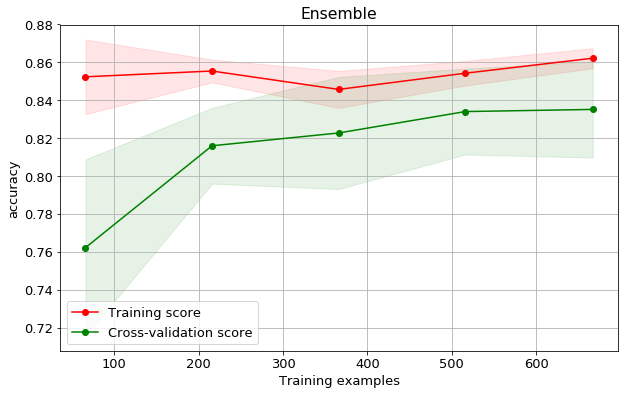

In [118]:
print (accuracy_score(y_test, clf_vc.predict(X_test)))
print (clf_vc)
plot_learning_curve(clf_vc, 'Ensemble', X, y, cv=4);

## Make submission

In [119]:
PassengerId = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)

In [120]:
def submission(model, fname, X):
    ans = pd.DataFrame(columns=['PassengerId', 'Survived'])
    ans.PassengerId = PassengerId
    ans.Survived = pd.Series(model.predict(X), index=ans.index)
    ans.to_csv(fname, index=False)

In [127]:
# test.head()

# 需要修复 test 中 'Title_Sir' 的顺序
# 这个 'Title_Sir' 是 手工添加到 test 中的, 
# 可能是因为 test 一个 Sir 的也没有, 但需要跟 train 对齐

# 问题是 'Title_Sir' 在 columns 的顺序也必须是正确的
cols = test.columns.tolist()
print(cols)
cols_fix = ['Sex', 'SibSp', 'Parch', 'Deck', 'Room', 'Group_num', 'NorAge', 'NorFare',
            'NorNames', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 
            'Pclass_3', 'Title_Lady', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 
            'Title_Officer', 'Title_Sir', 'Group_size_L', 'Group_size_M', 'Group_size_S']

test_cols_fix = test[cols_fix]

['Sex', 'SibSp', 'Parch', 'Deck', 'Room', 'Group_num', 'NorAge', 'NorFare', 'NorNames', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Lady', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Group_size_L', 'Group_size_M', 'Group_size_S', 'Title_Sir']


In [129]:
# test 中的 Title_Sir 字段的位置跟模型不符, 没弄明白为什么

# model => ['Sex', 'SibSp', 'Parch', 'Deck', 'Room', 'Group_num', 'NorAge', 'NorFare', 'NorNames', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Lady', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Sir', 'Group_size_L', 'Group_size_M', 'Group_size_S'] 
# test => ['Sex', 'SibSp', 'Parch', 'Deck', 'Room', 'Group_num', 'NorAge', 'NorFare', 'NorNames', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Lady', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Group_size_L', 'Group_size_M', 'Group_size_S', 'Title_Sir']

submission(clf_vc, 'Exploratory_Tutorial.csv', test_cols_fix)
